# Convoluation Neural Network


Each pixel in an image is associated with one or multiple numerical values, depending whether it black-and-white or colored. 

Previously...
- flattening values corresponding to each pixel into 1-d vetorrs
- spatial structure is discarded
- MLP is invariant to order of features, similar results are obtained regardless of whether we preserve order or not

Motivation
- want to leverage prior knowledge that nearby pixels are typically related to each other

CNN
- sample-efficient in achieving accurate model
- computationally efficient because: 1) require fewer parameters than fully-connected architectures; 2) convolutions are easy to parrallelize across GPU cores

# From Fuly-Connected Layers to Convoluations

Spatial invariance: Waldo looks the same regardless of his location
Desiderata:
- Translation invariance: in the earliest layer, the network should respond similarly to the same patch, regardless of where it appears in the image
- Locality principal: the earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. These local representations can be aggregated to make predictions at the whole image level

- convolution kernel / filter 
- channels / feature maps: allow models to capture multiple aspects of an image at each spatial location

# Convoluations for Images

**Cross-Correlation Operation**

An input tensor and a kernel tensor are combined to produce an output tensor through a cross-correlation operation


In [4]:
import torch
# input tensor X, kernel tensor K
def corr2d(X, K): 
  """Compute 2D cross-correlation"""
  h, w = K.shape
  Y = torch.zeros(X.shape[0] - h + 1, X.shape[1] - w + 1)
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      # element-wise multiplication
      Y[i, j] = (X[i:i + h, j:j+w] * K).sum()
  return Y

In [10]:
X = torch.arange(9).reshape((3,3))
K = torch.arange(4).reshape((2,2))
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

**Convolutional Layers**

A convolutional layer cross-correlates the input and kernel and adds a scalar bias to produce an output.

Parameters:
- kernel (typically randomly initialized)
- scalar bias

In [17]:
from torch import nn
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size)) # torch.rand(): uniform distribution on [0,1)
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    return corr2d(x, self.weight) + self.bias


**Object Edge Detection in Images**

A simple application of a convolutonal layer: detecting the edge of an object in an image by finding the location of the pixel change.

First, construct an image of 6x8 pixels. Middle 4 columns are black (0) and the remaining are white (1).

In [19]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, construct a kernel K with a height of 1 and a width of 2. When we perform cross-correlation operation, if the horizontally adjacent elements are the same, the output is 0. Otherwise, the output is non-zero. 

In [20]:
K = torch.tensor([[1.0, -1.0]])

In [21]:
corr2d(X, K)

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Apply the kenel to the transposed image, it vanishes. The kernel K only deteects vertical edges.

In [22]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

Play around.

In [44]:
X = torch.ones(6,8)
X[2:5, 2:6] = 0
X

tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

Kernel for detecting horizontal edges.

In [36]:
K = torch.tensor([[1.0],
                  [-1.0]])

In [37]:
corr2d(X, K)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1., -1., -1., -1.,  0.,  0.]])

Laplacian edge detector.

In [47]:
K = torch.tensor([[0.0,1.0,0.0],
                  [1.0,-4.0,1.0],
                  [0.0,1.0,0.0]])

In [46]:
corr2d(X, K)

tensor([[ 0., -1., -1., -1., -1.,  0.],
        [-1.,  2.,  1.,  1.,  2., -1.],
        [-1.,  1.,  0.,  0.,  1., -1.],
        [-1.,  2.,  1.,  1.,  2., -1.]])

Vertical Sobel edge detector.

In [49]:
K = torch.tensor([[-1.0,0.0,1.0],
                  [-2.0,0.0,2.0],
                  [-1.0,0.0,1.0]])

In [50]:
corr2d(X, K)

tensor([[-1., -1.,  0.,  0.,  1.,  1.],
        [-3., -3.,  0.,  0.,  3.,  3.],
        [-4., -4.,  0.,  0.,  4.,  4.],
        [-3., -3.,  0.,  0.,  3.,  3.]])

**Learning a Kernel**
Example using built-in class for 2d convoluttional layers and ignore the bias.

In [60]:
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

X = X.reshape((1,1,6,8)) # 4-d input (example, channel, height, width)
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # update kernel 
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i + 1) % 2 == 0:
    print(f'epoch {i + 1}, loss{l.sum():.3f}')


epoch 2, loss10.030
epoch 4, loss2.074
epoch 6, loss0.508
epoch 8, loss0.151
epoch 10, loss0.052


In [63]:
conv2d.weight.data.reshape(1,2)

tensor([[ 0.9629, -1.0070]])

Convolutional layer output is sometimes called a *feature map*, as it can be regarded as the learned representations (features) in the spatial dimensions (eg width & height) to the subsequent layer. 

In CNNs, for any element x of some layer, its receptive field refers to all the elements (from all the previous layers) that may affect the calculation of x during forward propagation. Receptive field may be larger than the actual size of the input.

# Padding & Striding

Since kernels generally have width and height greater than 1, after applying many successive convolutions, we tend up wind up with outputs that are considerably smaller than input. *Padding* is the most popular tool for handling this issue.

In other cases, we want reduce the dimensionality drastically. *Strided convolutions* are a popular technique that can help in these instances.

**Padding**

In many cases, we want to set padding height/width to kernel height/width - 1 to give the input and output the same height and width.

CNNs commonly use convolution kernels with odd height and weight values. 

Benefit: pad the same number of rows on top and bottom, and the same number of columns on left and right



In [64]:
import torch
from torch import nn
def comp_conv2d(conv2d, X):
  # (1,1) -> batch_sze = 1, num_channels = 1
  X = X.reshape((1,1) + X.shape)
  Y = conv2d(X)
  # exclude first 2 dimensions: examples and channels
  return Y.reshape(Y.shape[2:])

In [67]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

When the height and width of the convolution kernel are different, we can make the output and input have the same height and weight by setting different paddings numbers.

In [69]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5,3), padding=(2,1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

**Stride**

Reduce resolution of the output.

In practice, we rarely use inhomogeneous strides or padding.

In [70]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [73]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# Multiple Input and Multiple Output Channels

Example: RGB channels

When the input data contain multiple channels, we need to construct a convolution kernel with the same number of input channels as the input data.

Apply kernel to each channel, sum over the channel outputs.

**Multiple Input Channels**



In [ ]:
!pip install d2l

In [77]:
from d2l import torch as d2l
def corr2d_multi_in(X, K):
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [87]:
X = torch.tensor([[[0.0, 1.0, 2.0], 
                   [3.0, 4.0, 5.0], 
                   [6.0, 7.0, 8.0]],
                   [[1.0, 2.0, 3.0], 
                    [4.0, 5.0, 6.0], 
                    [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], 
                   [2.0, 3.0]], 
                  [[1.0, 2.0], 
                   [3.0, 4.0]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

**Multiple Output Channels**

It is essential to have multiple channels at each layer. In popular architectures, we increase the channel dimension as we go higher up in the neural network, typically downsampling to trade off spatial resolution for greater channel depth. 

In [91]:
def corr2d_multi_in_out(X, K):
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [83]:
torch.stack([torch.tensor([[1,2,3],[4,5,6]]), torch.tensor([[-1,-2,-3],[-4,-5,-6]])], 0)

tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[-1, -2, -3],
         [-4, -5, -6]]])

In [84]:
torch.stack([torch.tensor([[1,2,3],[4,5,6]]), torch.tensor([[-1,-2,-3],[-4,-5,-6]])], 1)

tensor([[[ 1,  2,  3],
         [-1, -2, -3]],

        [[ 4,  5,  6],
         [-4, -5, -6]]])

In [88]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [92]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

**1x1 Convolutional Layer**

Each element in the output is derived from a linear combination of elements at the same position in the input image. Each 1x1 convolutional layer is a fully-connected layer applied at every single pixel location.

In [95]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h * w))
  K = K.reshape((c_o, c_i))
  # matrix multiplication
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [97]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# Pooling

As we process images, we want to gradually reduce the spatial resolution of ourr hidden representations, aggregating information so that the higher up we go in the network, the larger the receptive field (in the input) to which each hidden is sensitive.

Purposes:
- Mitigating the sensitivity of convolutional layers to location
- Spatially downsampling representations

**Maximum Pooling & Average Pooling**

Pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape *pooling window*. Unlinke cross-correlation computation, pooling layer contain no parameter. These operations are called *maximum pooling* and *average pooling*.

In [99]:
import torch

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [100]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [101]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

**Padding and Stride**

As with convolutional layers, pooling layers can also change the output shape.

In [103]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [104]:
pool2d = nn.MaxPool2d(3)
pool2d

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)

In [105]:
pool2d(X)

tensor([[[[10.]]]])

In [106]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [107]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

**Multiple Channels**

When processing multi-channel input data, the pooling layer pools each input channel separately, rather than summing the inputs up over channels as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels. 

In [108]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [109]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# Convoluation Neural Networks Example: LeNet

Assemble a fully-functional CNN!



LeNet consists of 2 parts:
- a convolutional encoder consisting of two convolutional layers
- a dense block consisting of three fully-connected layers

The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. (max pooling and relu work better, but not discovered yet)

In [7]:
import torch
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [8]:
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [13]:
train_iter

In [14]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


In [16]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # save memory and speed up training
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
!pip install matplotlib==3.1.3

loss 0.467, train acc 0.826, test acc 0.728
20287.3 examples/sec on cuda:0


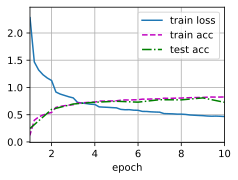

In [21]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Summary
- In a CNN, convolutional layers are typically arranged so that they grardually decrease the spatial resolution of the representations, while increasing the number of channels
- In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully-connected layers prior to emitting output